In [1]:
import pandas as pd
import numpy as np
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file

dataset = "DSGD.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]


X_train, X_test, y_train, y_test = train_test_split(X, 2 * y - 3, test_size=0.2, random_state=42)

def calc_L(b=97):
    s = len(X_train) // b
    summ = (np.linalg.norm(X_train, axis=1)**2).mean()
    L = summ / 4
    lambda_ = L/1000
    return L, b, s, lambda_


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math

num_nodes_ = 25
b_ = 50
D_i_ = np.random.normal(0, 1, 1000)

# Define the network topology
def readFile(fileName):
    network_topology = {}

    with open(fileName) as f:
        content = f.readlines()

    content = [x.strip() for x in content]

    for line in content:
        values = line.split(" ")
        node1 = int(values[0])
        node2 = int(values[1])

        if node1 not in network_topology:
            network_topology[node1] = []
        if node2 not in network_topology:
            network_topology[node2] = []

        network_topology[node1].append(node2)
        network_topology[node2].append(node1)
    # Sort the dictionary by keys
    sorted_network_topology = dict(sorted(network_topology.items()))

    return sorted_network_topology


network_topology_ = readFile('Topologies/Ring25.txt')
print(network_topology_)


def divide_into_batches(X_train, y_train, batch_size):
    num_samples = X_train.shape[0]

    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1
    X_batches = np.array_split(X_train, num_batches)
    y_batches = np.array_split(y_train, num_batches)

    return X_batches, y_batches

def ll(z, y):
    return np.log(1+np.exp(-y*z))

def compute_f(lambda_, w, b, s):
    tmp = (lambda_/2) * np.linalg.norm(w, ord=2)**2
    ans = []
    for j in range(s):
        l = [ll(np.dot(X[i], w), y[i]) for i in range((j-1)*b, j*b)]
        summ = np.sum(l)/b + tmp
        ans.append(summ)

    return np.sum(ans)/s


# Define a function to compute local gradients
def compute_local_gradients(X_, y_, xi, w, lambda_):
    # Compute gradients using a random subset of the training data
    b = len(X_)
    numerator = -y_[xi][:, None] * X_[xi]
    tmp = y_[xi] * np.dot(X_[xi], w)
    denominator = (1+ np.exp(tmp))[:, None]
    gradient = (numerator/denominator).mean(axis=0) + lambda_*w

    noise0 = np.random.normal(0, 0, gradient.shape)
    noise1 = np.random.normal(0, 1, gradient.shape)
    noise10 = np.random.normal(0, 10, gradient.shape)

    gradient_with_noise0 = gradient + noise0
    gradient_with_noise1 = gradient + noise1
    gradient_with_noise10 = gradient + noise10

    return gradient_with_noise0, gradient_with_noise1, gradient_with_noise10

def prepare(b, x_0):
    L, b, s, lambda_ = calc_L(b)

    X, y = divide_into_batches(X_train, y_train, b)
    g_0 = [np.linalg.norm(compute_local_gradients(X, y, i, x_0, lambda_), ord=2) for i in range(num_nodes_)]
    eta = 10**(-2)
    def error(w, j):
        return np.mean(np.linalg.norm((w[j] - g_0[j]), ord=2)**2)

    return L, b, s, X, y, g_0, eta, lambda_, error
x_0_ = np.random.randn(X_train.shape[1])
L_, b_, s_, X_, y_, g_0_, eta_, lambda__, error_ = prepare(b_, x_0_)


# Define a function for communication
def exchange_information(num_nodes, new_model_parameters, model_parameters, network_topology):
    # Exchange information with neighboring nodes in the network
    
    for node_id in range(num_nodes):
        if node_id not in network_topology:
            continue
        neighbors = network_topology[node_id]
        sum_ = 0
        for neighbor in neighbors:
            # Send local parameters to the neighbor and receive their parameters
            sum_ += new_model_parameters[neighbor]
        model_parameters[node_id] = sum_/len(neighbors)
    return model_parameters

# Define a function to update local parameters
def update_local_parameters(model_parameter, eta, gradient, t):
    # Update local parameters using the received gradients and a local optimization algorithm (e.g., SGD)
    new_model_parameter = model_parameter - eta(t) * gradient
    return new_model_parameter

# Training loop
def run_experiment(num_nodes, X, y, model_parameters, eta, lambda_, network_topology, sigma=0, zeta=0, num_iterations = 400, learning_rate = 0.01, eps = 10**(-5)):
    convergence_data = []
    for t in range(num_iterations):
        new_model_parameters = np.zeros_like(model_parameters)
        for node_id in range(num_nodes):
            # Chosing random batch
            i = np.random.randint(0, len(X))
            # Compute local gradients
            gradient = compute_local_gradients(X, y, i, model_parameters[node_id], lambda_)[sigma]
            gradient += zeta
            # Update local parameters
            new_model_parameters[node_id] = update_local_parameters(model_parameters[node_id], eta, gradient, t)

        # Communication and updating model_parameters
        model_parameters = exchange_information(num_nodes, new_model_parameters, model_parameters, network_topology)
        
        # Aggregate model parameters
        global_model = np.min(model_parameters)
        
        # Compute convergence criterion and store data
        convergence_criterion = np.mean(np.linalg.norm((model_parameters[node_id] - global_model), ord=2)**2)
        convergence_data.append(convergence_criterion)

        
        if convergence_criterion < eps:
            return convergence_data
    
    return convergence_data


{0: [1, 24], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6], 6: [5, 7], 7: [6, 8], 8: [7, 9], 9: [8, 10], 10: [9, 11], 11: [10, 12], 12: [11, 13], 13: [12, 14], 14: [13, 15], 15: [14, 16], 16: [15, 17], 17: [16, 18], 18: [17, 19], 19: [18, 20], 20: [19, 21], 21: [20, 22], 22: [21, 23], 23: [22, 24], 24: [0, 23]}


{0: [1, 24], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6], 6: [5, 7], 7: [6, 8], 8: [7, 9], 9: [8, 10], 10: [9, 11], 11: [10, 12], 12: [11, 13], 13: [12, 14], 14: [13, 15], 15: [14, 16], 16: [15, 17], 17: [16, 18], 18: [17, 19], 19: [18, 20], 20: [19, 21], 21: [20, 22], 22: [21, 23], 23: [22, 24], 24: [0, 23]}


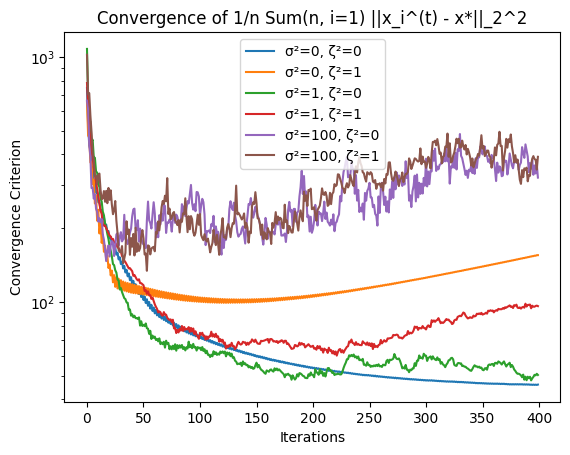

In [24]:
# Run multiple experiments with different σ¯^2 and ¯ζ^2
experiments_ = []
sigma_values_ = [0, 1, 2]
zeta_values_ = [0, 1]
convergence_data_ = []
print(network_topology_)

for sigma in sigma_values_:
    for zeta in zeta_values_:
        model_parameters_ = [np.random.randn(X_train.shape[1]) 
                            for _ in range(num_nodes_)]
        convergence_data_.append(run_experiment(num_nodes_, X_, y_, 
                    model_parameters_, lambda t: eta_, lambda__, network_topology_, sigma=sigma, zeta=zeta))


experiments_.append((sigma_values_, zeta_values_, convergence_data_))

# Plot the convergence data for each experiment
plt.figure(1)
plt.title('Convergence of 1/n Sum(n, i=1) ||x_i^(t) - x*||_2^2')
i = 0
for sigma in sigma_values_:
    for zeta in zeta_values_:
        
        sigma_ = 100 if sigma==2 else sigma
        plt.plot(convergence_data_[i], label=f'σ²={sigma_}, ζ²={zeta}')
        i+=1
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Convergence Criterion')
plt.legend()
plt.show()



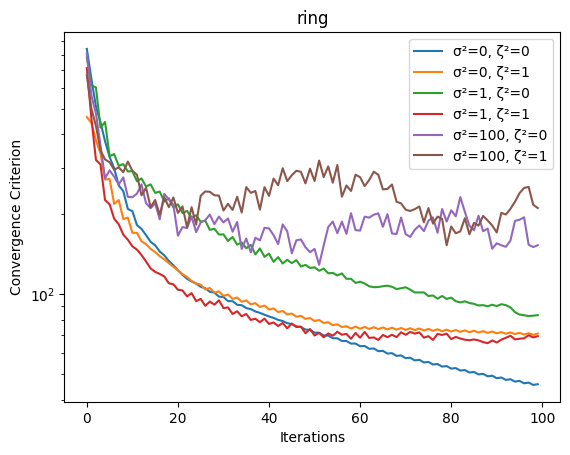

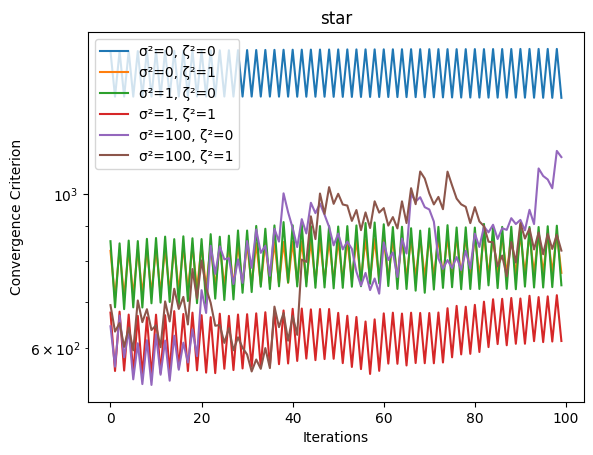

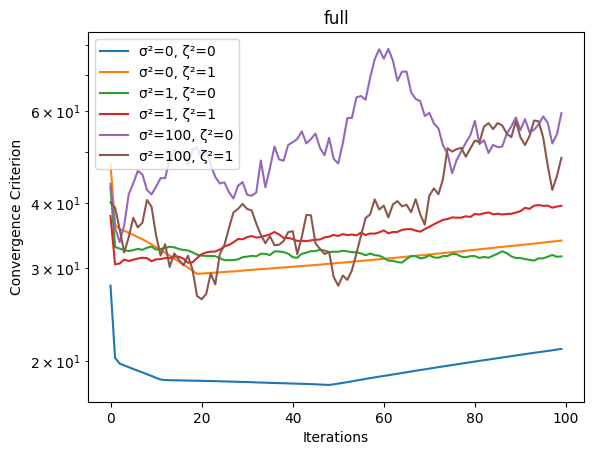

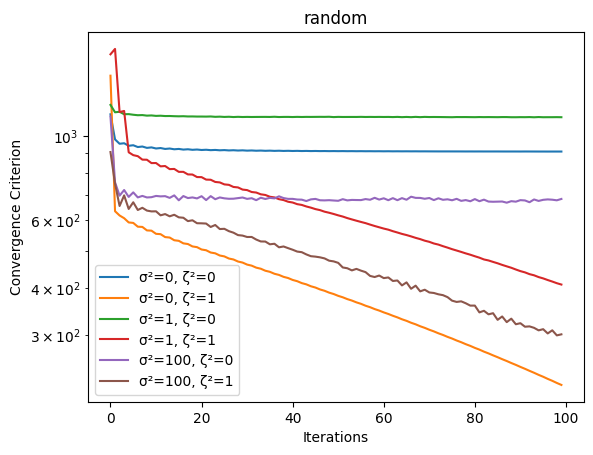

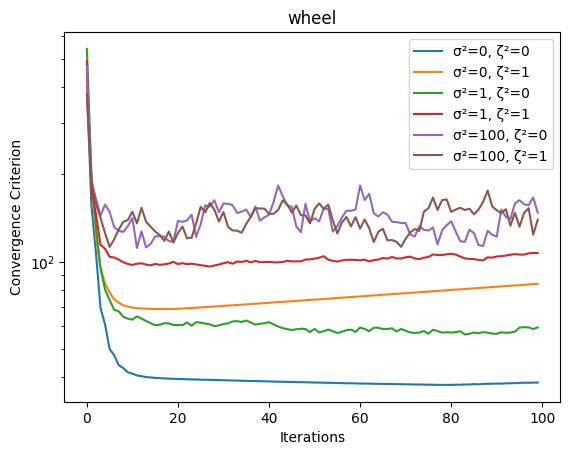

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math

num_nodes_ = 25
b_ = 50
D_i_ = np.random.normal(0, 1, 1000)
x_0_ = np.random.randn(X_train.shape[1])
L_, b_, s_, X_, y_, g_0_, eta_, lambda__, error_ = prepare(b_, x_0_)
experiments_ = []
sigma_values_ = [0, 1, 2]
zeta_values_ = [0, 1]
convergence_data_ = []

network_topology_ring = readFile('Topologies/Ring25.txt')
network_topology_star = readFile('Topologies/Star25.txt')
network_topology_full = readFile('Topologies/Full25.txt')
network_topology_random = readFile('Topologies/Random25.txt')
network_topology_wheel = readFile('Topologies/Wheel25.txt')
topologies = ['ring', 'star', 'full', 'random', 'wheel']

for topology in topologies:

    if topology == 'ring':
        topology_ =  network_topology_ring
    if topology == 'star':
        topology_ =  network_topology_star
    if topology == 'full':
        topology_ =  network_topology_full
    if topology == 'random':
        topology_ =  network_topology_random
    if topology == 'wheel':
        topology_ =  network_topology_wheel

    for sigma in sigma_values_:
        for zeta in zeta_values_:
            model_parameters_ = [np.random.randn(X_train.shape[1]) 
                                for _ in range(num_nodes_)]
            convergence_data_.append(run_experiment(num_nodes_, X_, y_, 
                        model_parameters_, lambda t: eta_, lambda__, topology_, sigma=sigma, zeta=zeta, num_iterations=100))


experiments_.append((sigma_values_, zeta_values_, convergence_data_))

# Plot the convergence data for each experiment
k=0
i = 0
for topology in topologies:

    plt.figure(k)
    plt.title(topology)
    
    for sigma in sigma_values_:
        for zeta in zeta_values_:
            sigma_ = 100 if sigma==2 else sigma
            plt.plot(convergence_data_[i], label=f'σ²={sigma_}, ζ²={zeta}')
            i+=1
    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Convergence Criterion')
    plt.legend()
    plt.show()
    k+=1



{0: [1, 24], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6], 6: [5, 7], 7: [6, 8], 8: [7, 9], 9: [8, 10], 10: [9, 11], 11: [10, 12], 12: [11, 13], 13: [12, 14], 14: [13, 15], 15: [14, 16], 16: [15, 17], 17: [16, 18], 18: [17, 19], 19: [18, 20], 20: [19, 21], 21: [20, 22], 22: [21, 23], 23: [22, 24], 24: [0, 23]}


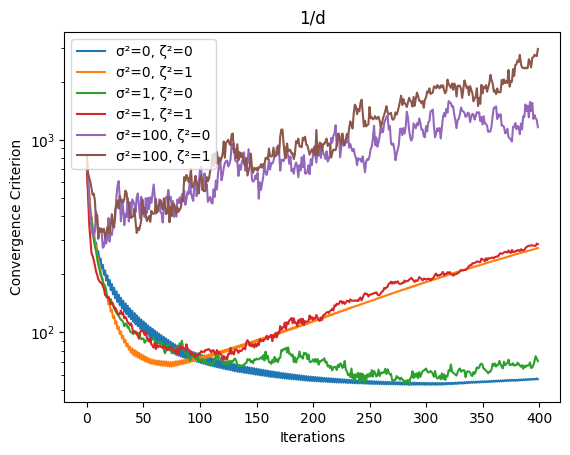

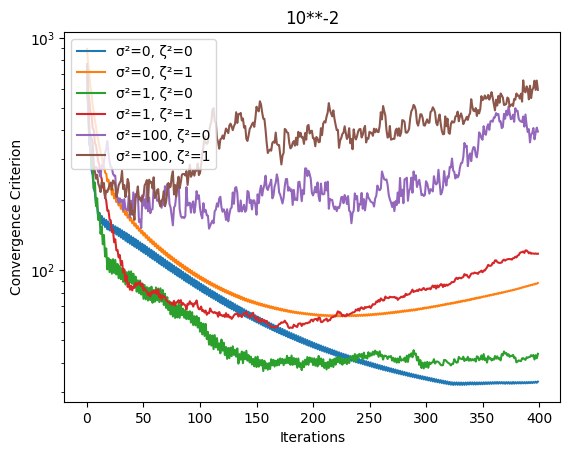

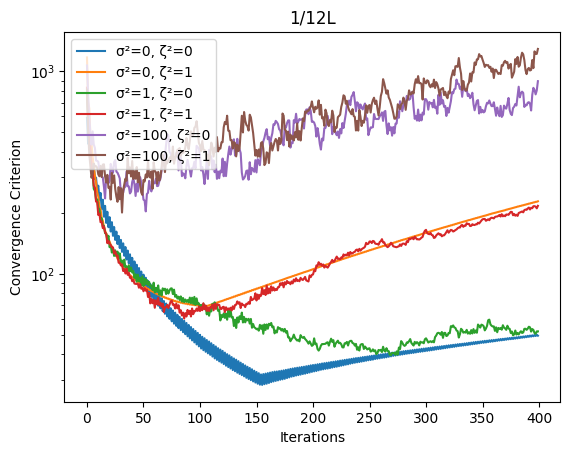

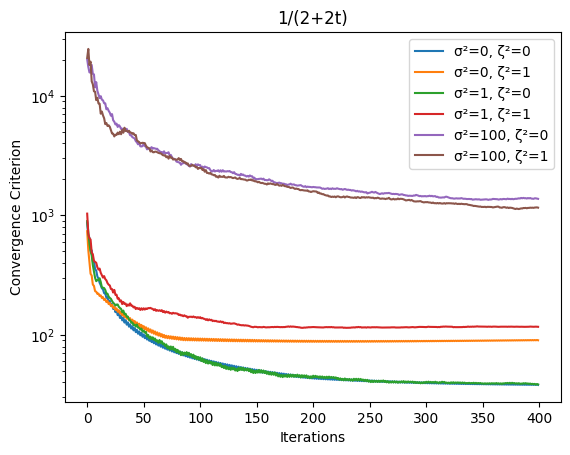

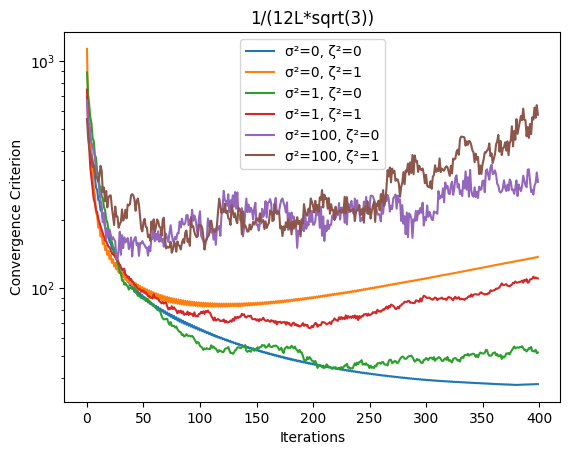

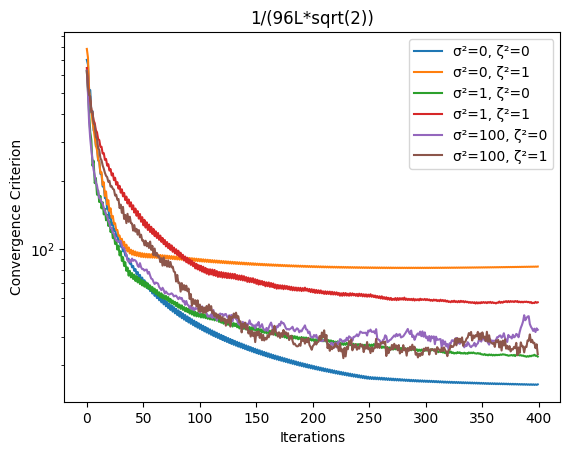

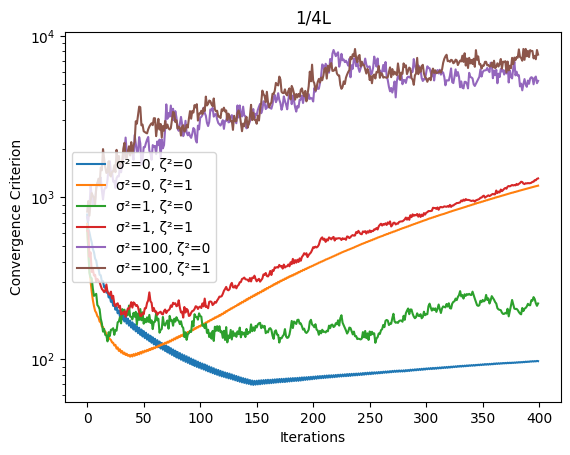

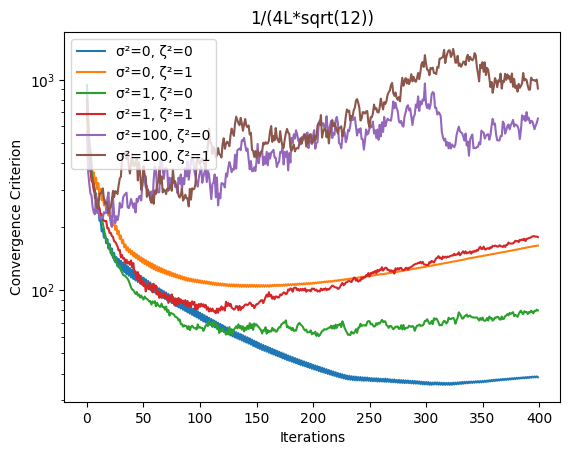

In [10]:
# Run multiple experiments with different σ¯^2 and ¯ζ^2
experiments_ = []
sigma_values_ = [0, 1, 2]
zeta_values_ = [0, 1]
convergence_data_ = []
print(network_topology_)
eta_list_ = [lambda t: 1/b_, lambda t: 10**-2, lambda t: 1/(12*L_), lambda t: 1/(2+2*t), lambda t: 1/(12*np.sqrt(3)*L_), lambda t: 1/(96*np.sqrt(2)*L_), lambda t: 1/(4*L_), lambda t: 1/(4*L_*np.sqrt(12))]
eta_labels = ['1/d', '10**-2', '1/12L', '1/(2+2t)', '1/(12L*sqrt(3))', '1/(96L*sqrt(2))', '1/4L', '1/(4L*sqrt(12))']

for eta in eta_list_:
    for sigma in sigma_values_:
        for zeta in zeta_values_:
            model_parameters_ = [np.random.randn(X_train.shape[1]) 
                                for _ in range(num_nodes_)]
            convergence_data_.append(run_experiment(num_nodes_, X_, y_, 
                        model_parameters_, eta, lambda__, network_topology_, sigma=sigma, zeta=zeta))


experiments_.append((sigma_values_, zeta_values_, convergence_data_))

# Plot the convergence data for each experiment
i = 0
k = 0
for eta in eta_labels:
    plt.figure(k)
    plt.title(eta)
    
    for sigma in sigma_values_:
        for zeta in zeta_values_:
            
            sigma_ = 100 if sigma==2 else sigma
            plt.plot(convergence_data_[i], label=f'σ²={sigma_}, ζ²={zeta}')
            i+=1
    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Convergence Criterion')
    plt.legend()
    plt.show()
    k+=1

